# Problem 2: Getting familiar with TensorFlow

*TensorFlow* is one of the most popular deep learning framework developed by Google. If you are new to TensorFlow, please read and play with the sample in [Getting started with TensorFlow](https://www.tensorflow.org/get_started/get_started) to get started.

* <b>Learning Objective:</b> In Problem 1, you implemented a fully connected network from scratch on your own. Very tedious to do it all by yourself, right? Well, we actually feel the same thing, that's why we are using tools instead of doing everything from scratch. For this part of the assignment, we will familiarize you with a widely-used deep learning framework developed by Google, TensorFlow and walk you through convolutional neural networks and show how to train them.
* <b>Provided Codes:</b> We provide the Template class for a simple CNN model as BaseModel, predefined skeletons for conv2d() and max_pool(), as well as the dataset preprocessing parts.
* <b>TODOs:</b> You are asked to implement the BaseModel following the detailed instructions and design your own model in YourModel to achieve a reasonably good performance for classification task on CIFAR-10 dataset.

## Import libraries

In [55]:
# Import required libraries
# Add whatever you want
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from lib.datasets import CIFAR10_tf

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# We recommend to use tensorflow==1.14.0
print("TensorFlow Version {}".format(tf.__version__))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
TensorFlow Version 1.14.0


## Load datasets
Download [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz) and load the dataset. In this assignment, we will use the standard 50,000 images for training and 10,000 images for test.

In [56]:
# Configuration
num_training = 49000
num_validation = 50000 - num_training
num_test = 10000

data = CIFAR10_tf(num_training=num_training,
                  num_validation=num_validation,
                  num_test=num_test)

# Load cifar-10 data
X_train, Y_train = data['data_train'], data['labels_train']
X_val, Y_val = data['data_val'], data['labels_val']
X_test, Y_test = data['data_test'], data['labels_test']

# Check the shape of the dataset
assert X_train.shape == (num_training, 32, 32, 3)
assert Y_train.shape == (num_training, )
assert X_val.shape == (num_validation, 32, 32, 3)
assert Y_val.shape == (num_validation, )
assert X_test.shape == (num_test, 32, 32, 3)
assert Y_test.shape == (10000, )

## Question 2-1 [10pt]

Using the code provided, implement a neural network architecture with an optimization routine according to the specification provided below.

**Model:**
- Input image with the size 32x32x3
- 7x7 convolutional layer with 32 filters, stride of 1, and padding 'SAME'
- ReLU activation layer
- 3x3 max pooling layer with a stride of 2
- 5x5 convolutional layer with 64 filters, stride of 1, and padding 'SAME'
- ReLU activation layer
- 3x3 max pooling layer with a stride of 2
- Flatten layer (8x8x64 -> 4096)
- Fully-connected layer with 384 output units (4096 -> 384)
- ReLU activation layer
- Fully-connected layer with 10 output units (384 -> 10)
- Output logits (10)

**Optimizer:**
- Adam optimizer

**Learning rate:**
- Set start learning rate as 5e-4 and apply exponential decay every 500 steps with a base of 0.96
- Use 'tf.train.exponential_decay' and 'tf.train.AdamOptimizer'

**Loss:**
- Softmax cross entropy loss
- Use 'tf.nn.softmax_cross_entropy_with_logits_v2'


Your model **should** achieve about 55% accuracy on test set in 5 epochs using provided evaluation code.

You can modify the template code as you want.

## Define your layers

In [57]:
# Define max pooling and conv layers

def conv2d(input, kernel_size, stride, num_filter):
    stride_shape = [1, stride, stride, 1]
    filter_shape = [kernel_size, kernel_size, input.get_shape()[3], num_filter]

    W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
    b = tf.get_variable('b', [1, 1, 1, num_filter], initializer=tf.constant_initializer(0.0))
    return tf.nn.conv2d(input, W, stride_shape, padding='SAME') + b

def max_pool(input, kernel_size, stride):
    ksize = [1, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, 1]
    return tf.nn.max_pool(input, ksize=ksize, strides=strides, padding='SAME')

#############################################################################
# TODO: Complete the following functions                                    #
#############################################################################
def flatten(input):
    """
        - input: input tensors
    """
    return tf.layers.flatten(input)

def fc(input, num_output):
    """
        - input: input tensors
        - num_output: int, the output dimension
    """
    return tf.layers.dense(input,units=num_output)

def norm(input):
        return tf.layers.batch_normalization(input)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

## Sample convolutional neural network

In [58]:
class BaseModel(object):
    def __init__(self):
        self.num_epoch = 5
        self.batch_size = 64
        self.log_step = 50
        self._build_model()

    def _model(self):
        print('-' * 5 + '  Sample model  ' + '-' * 5)

        print('intput layer: ' + str(self.X.get_shape()))

        with tf.variable_scope('conv1'):
            self.conv1 = conv2d(self.X, 7, 1, 32)
            self.relu1 = tf.nn.relu(self.conv1)
            self.pool1 = max_pool(self.relu1, 3, 2)            
            print('conv1 layer: ' + str(self.pool1.get_shape()))

        with tf.variable_scope('conv2'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.conv2 = conv2d(self.pool1, 5, 1, 64)
            self.relu2 = tf.nn.relu(self.conv2)
            self.pool2 = max_pool(self.relu2, 3, 2) 
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('conv2 layer: ' + str(self.pool2.get_shape()))

        #############################################################################
        # TODO: Flatten the output tensor from conv2 layer                          #
        #############################################################################
        #with tf.variable_scope('flatten'):
        self.flat = flatten(self.pool2)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################      
        print('flat layer: ' + str(self.flat.get_shape()))

        with tf.variable_scope('fc3'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.fc3 = fc(self.flat, 384)
            self.relu3 = tf.nn.relu(self.fc3)
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('fc3 layer: ' + str(self.relu3.get_shape()))
            
        with tf.variable_scope('fc4'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.fc4 = fc(self.relu3, 10)
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('fc4 layer: ' + str(self.fc4.get_shape()))
            
        # Return the last layer
        return self.fc4

    def _input_ops(self):
        # Placeholders
        self.X = tf.placeholder(tf.float32, [None, 32, 32, 3])
        self.Y = tf.placeholder(tf.int64, [None])

        #############################################################################
        # TODO: You can add any placeholders                                        #
        #############################################################################

        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def _build_optimizer(self):
        #############################################################################
        # TODO: Adam optimizer 'self.train_op' that minimizes 'self.loss_op'        #
        #############################################################################
        global_step = tf.Variable(0, trainable=False)
        self.learning_rate = tf.train.exponential_decay(5e-4, global_step, 500, 0.96, staircase=True)
        self.train_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss_op)
        

        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
        
    def _loss(self, labels, logits):
        #############################################################################
        # TODO: Softmax cross entropy loss 'self.loss_op'                           #
        #############################################################################
        self.loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=labels))
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def _build_model(self):
        # Define input variables
        self._input_ops()

        # Convert Y to one-hot vector
        labels = tf.one_hot(self.Y, 10)

        # Build a model and get logits
        logits = self._model()

        # Compute loss
        self._loss(labels, logits)
        
        # Build optimizer
        self._build_optimizer()

        # Compute accuracy
        predict = tf.argmax(logits, 1)
        correct = tf.equal(predict, self.Y)
        self.accuracy_op = tf.reduce_mean(tf.cast(correct, tf.float32))
        
    def train(self, sess, X_train, Y_train, X_val, Y_val):
        sess.run(tf.global_variables_initializer())

        step = 0
        losses = []
        accuracies = []
        print('-' * 5 + '  Start training  ' + '-' * 5)
        for epoch in range(self.num_epoch):
            print('train for epoch %d' % epoch)
            for i in range(num_training // self.batch_size):
                X_ = X_train[i * self.batch_size:(i + 1) * self.batch_size][:]
                Y_ = Y_train[i * self.batch_size:(i + 1) * self.batch_size]

                #############################################################################
                # TODO: You can change feed data as you want                                #
                #############################################################################
                feed_dict = {self.X : X_, self.Y : Y_} 
                #############################################################################
                #                             END OF YOUR CODE                              #
                #############################################################################
                fetches = [self.train_op, self.loss_op, self.accuracy_op]

                _, loss, accuracy = sess.run(fetches, feed_dict=feed_dict)
                losses.append(loss)
                accuracies.append(accuracy)

                if step % self.log_step == 0:
                    print('iteration (%d): loss = %.3f, accuracy = %.3f' %
                        (step, loss, accuracy))
                step += 1

            # Print validation results
            print('validation for epoch %d' % epoch)
            val_accuracy = self.evaluate(sess, X_val, Y_val)
            print('-  epoch %d: validation accuracy = %.3f' % (epoch, val_accuracy))
            
        #############################################################################
        # TODO: Plot training curve                                                 #
        #############################################################################
        # Graph 1. X: iteration (training step), Y: training loss
            plt.subplot(2, 1, 1)
            plt.title('Loss during training')
            plt.xlabel('iteration (training step)')
            plt.ylabel('training loss')
            plt.plot(range(len(losses)), losses, label='loss_training')    
            
        # Graph 2. X: iteration (training step), Y: training accuracy
            plt.subplot(2,1,2)
            plt.title('Accuracy during training')
            plt.ylabel('Accuracy')
            plt.xlabel('iteration (training step)')
            plt.plot(range(len(accuracies)), accuracies, label='training Accuracy')
            plt.show()
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def evaluate(self, sess, X_eval, Y_eval):
        eval_accuracy = 0.0
        eval_iter = 0
        for i in range(X_eval.shape[0] // self.batch_size):
            X_ = X_eval[i * self.batch_size:(i + 1) * self.batch_size][:]
            Y_ = Y_eval[i * self.batch_size:(i + 1) * self.batch_size]
            
            #############################################################################
            # TODO: You can change feed data as you want                                #
            #############################################################################
            feed_dict = {self.X : X_, self.Y : Y_}
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            accuracy = sess.run(self.accuracy_op, feed_dict=feed_dict)
            eval_accuracy += accuracy
            eval_iter += 1
        return eval_accuracy / eval_iter

-----  Sample model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 16, 16, 32)
conv2 layer: (?, 8, 8, 64)


W0930 22:34:54.405615 14672 deprecation.py:323] From <ipython-input-7-5b6b5a0bbc28>:23: flatten (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.flatten instead.
W0930 22:34:55.126021 14672 deprecation.py:323] From <ipython-input-7-5b6b5a0bbc28>:30: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0930 22:34:55.132421 14672 deprecation.py:506] From C:\Users\mohan\Anaconda3\envs\tensorflow_cpu_env\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


flat layer: (?, 4096)
fc3 layer: (?, 384)
fc4 layer: (?, 10)
-----  Start training  -----
train for epoch 0
iteration (0): loss = 21.140, accuracy = 0.141
iteration (50): loss = 2.176, accuracy = 0.234
iteration (100): loss = 2.117, accuracy = 0.234
iteration (150): loss = 1.795, accuracy = 0.406
iteration (200): loss = 1.594, accuracy = 0.453
iteration (250): loss = 1.641, accuracy = 0.438
iteration (300): loss = 1.662, accuracy = 0.297
iteration (350): loss = 1.772, accuracy = 0.312
iteration (400): loss = 1.733, accuracy = 0.391
iteration (450): loss = 1.485, accuracy = 0.547
iteration (500): loss = 1.597, accuracy = 0.469
iteration (550): loss = 1.472, accuracy = 0.422
iteration (600): loss = 1.584, accuracy = 0.500
iteration (650): loss = 1.352, accuracy = 0.578
iteration (700): loss = 1.514, accuracy = 0.547
iteration (750): loss = 1.795, accuracy = 0.344
validation for epoch 0
-  epoch 0: validation accuracy = 0.489


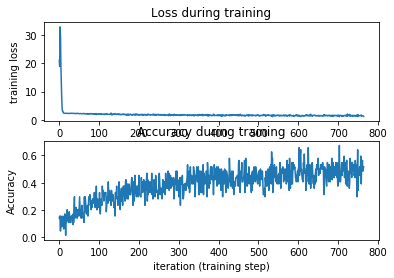

train for epoch 1
iteration (800): loss = 1.344, accuracy = 0.469
iteration (850): loss = 1.393, accuracy = 0.531
iteration (900): loss = 1.101, accuracy = 0.625
iteration (950): loss = 1.339, accuracy = 0.547
iteration (1000): loss = 1.497, accuracy = 0.500
iteration (1050): loss = 1.333, accuracy = 0.469
iteration (1100): loss = 1.437, accuracy = 0.469
iteration (1150): loss = 1.119, accuracy = 0.547
iteration (1200): loss = 1.611, accuracy = 0.500
iteration (1250): loss = 1.094, accuracy = 0.609
iteration (1300): loss = 0.994, accuracy = 0.547
iteration (1350): loss = 1.275, accuracy = 0.547
iteration (1400): loss = 1.175, accuracy = 0.562
iteration (1450): loss = 1.397, accuracy = 0.531
iteration (1500): loss = 1.370, accuracy = 0.484
validation for epoch 1
-  epoch 1: validation accuracy = 0.595


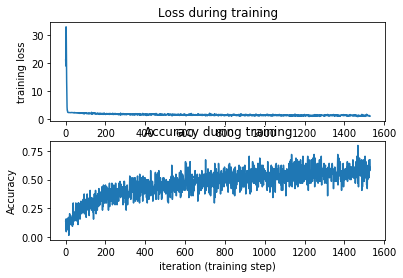

train for epoch 2
iteration (1550): loss = 1.302, accuracy = 0.547
iteration (1600): loss = 1.163, accuracy = 0.625
iteration (1650): loss = 1.187, accuracy = 0.578
iteration (1700): loss = 1.240, accuracy = 0.484
iteration (1750): loss = 1.092, accuracy = 0.625
iteration (1800): loss = 1.204, accuracy = 0.531
iteration (1850): loss = 1.275, accuracy = 0.500
iteration (1900): loss = 0.850, accuracy = 0.734
iteration (1950): loss = 1.152, accuracy = 0.578
iteration (2000): loss = 1.052, accuracy = 0.531
iteration (2050): loss = 1.172, accuracy = 0.562
iteration (2100): loss = 1.179, accuracy = 0.578
iteration (2150): loss = 1.268, accuracy = 0.578
iteration (2200): loss = 1.131, accuracy = 0.578
iteration (2250): loss = 0.814, accuracy = 0.672
validation for epoch 2
-  epoch 2: validation accuracy = 0.596


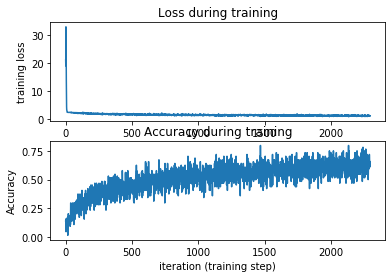

train for epoch 3
iteration (2300): loss = 1.002, accuracy = 0.625
iteration (2350): loss = 1.022, accuracy = 0.625
iteration (2400): loss = 1.069, accuracy = 0.578
iteration (2450): loss = 0.964, accuracy = 0.609
iteration (2500): loss = 0.894, accuracy = 0.688
iteration (2550): loss = 0.883, accuracy = 0.703
iteration (2600): loss = 1.244, accuracy = 0.578
iteration (2650): loss = 0.879, accuracy = 0.688
iteration (2700): loss = 1.013, accuracy = 0.703
iteration (2750): loss = 1.042, accuracy = 0.672
iteration (2800): loss = 0.960, accuracy = 0.688
iteration (2850): loss = 1.000, accuracy = 0.656
iteration (2900): loss = 0.867, accuracy = 0.688
iteration (2950): loss = 0.976, accuracy = 0.594
iteration (3000): loss = 0.941, accuracy = 0.703
iteration (3050): loss = 1.050, accuracy = 0.656
validation for epoch 3
-  epoch 3: validation accuracy = 0.578


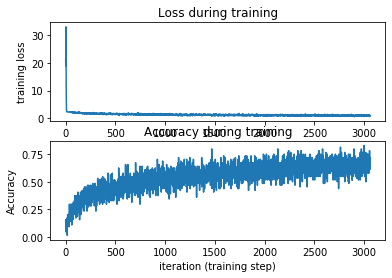

train for epoch 4
iteration (3100): loss = 0.759, accuracy = 0.656
iteration (3150): loss = 0.827, accuracy = 0.641
iteration (3200): loss = 1.189, accuracy = 0.641
iteration (3250): loss = 1.051, accuracy = 0.625
iteration (3300): loss = 0.831, accuracy = 0.688
iteration (3350): loss = 0.920, accuracy = 0.719
iteration (3400): loss = 0.846, accuracy = 0.734
iteration (3450): loss = 0.631, accuracy = 0.734
iteration (3500): loss = 1.025, accuracy = 0.625
iteration (3550): loss = 0.974, accuracy = 0.703
iteration (3600): loss = 0.793, accuracy = 0.734
iteration (3650): loss = 0.955, accuracy = 0.672
iteration (3700): loss = 0.791, accuracy = 0.703
iteration (3750): loss = 1.060, accuracy = 0.656
iteration (3800): loss = 0.944, accuracy = 0.688
validation for epoch 4
-  epoch 4: validation accuracy = 0.610


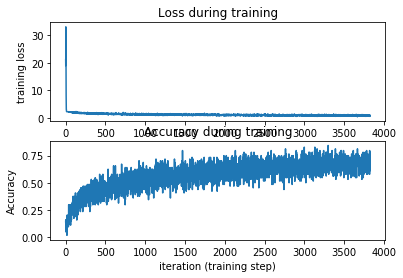

***** test accuracy: 0.600
Model saved in lib/tf_models/problem2/csci-599_sample.ckpt


In [9]:
# Clear old computation graphs
tf.reset_default_graph()

# Train our sample model
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)) as sess:
    with tf.device('/cpu:0'):
        model = BaseModel()
        model.train(sess, X_train, Y_train, X_val, Y_val)
        accuracy = model.evaluate(sess, X_test, Y_test)
        print('***** test accuracy: %.3f' % accuracy)
        saver = tf.train.Saver()
        model_path = saver.save(sess, "lib/tf_models/problem2/csci-599_sample.ckpt")
        print("Model saved in %s" % model_path)

## Question 2-2 [15pt]

Implement your own model. 

You can modify the template code as you want and you can use GPU for fast training. For GPU usage, simply change the following line of the training block:  
from `with tf.device('/cpu:0')` to `with tf.device('/GPU:0')` and you can set your desired device number.

These are the techniques that you can try:
- Data preprocessing
- Data augmentation
- Batch normalization
- Dropout
- More convolutional layers
- More training epochs
- Learning rate decay
- Any other models and techniqes

The rubrics for this question is:
* 15 points when test accuracy >= 75%
* 10 points when test accuracy >= 70%
* 5 points when test accuracy >= 60%

In [67]:
#############################################################################
# TODO: Define YourModel - same as in Problem 2.
# Simply Copy & Paste your code block (with implementation) for YourModel here.
# We will load your saved model below.
#############################################################################
class YourModel(BaseModel):
    def __init__(self):
        super(YourModel, self).__init__()
        self.num_epoch = 15


    def _model(self):
        print('-' * 5 + '  Your model  ' + '-' * 5)

        #############################################################################
        # TODO: Implement you own model here                                        #
        #############################################################################
        print('intput layer: ' + str(self.X.get_shape()))

        with tf.variable_scope('conv1'):
            self.conv1 = conv2d(self.X, 7, 1, 32)
            self.relu1 = tf.nn.leaky_relu(self.conv1)
            self.norm1 = norm(self.relu1)           
            print('conv1 layer: ' + str(self.norm1.get_shape()))

        with tf.variable_scope('conv2'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.conv2 = conv2d(self.norm1, 5, 1, 64)
            self.relu2 = tf.nn.leaky_relu(self.conv2)
            self.norm2 = norm(self.relu2)
            self.pool2 = max_pool(self.norm2, 3, 2)
            print('conv2 layer: ' + str(self.pool2.get_shape()))
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
        with tf.variable_scope('conv3'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.conv3 = conv2d(self.pool2, 5, 1, 64)
            self.relu3 = tf.nn.leaky_relu(self.conv3)
            self.norm3 = norm(self.relu3)
            print('conv3 layer: ' + str(self.norm3.get_shape()))
        
        with tf.variable_scope('conv4'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.conv4 = conv2d(self.norm3, 3, 1, 128)
            self.relu4 = tf.nn.leaky_relu(self.conv4)
            self.norm4 = norm(self.relu4)
            self.pool4 = max_pool(self.norm4, 3, 2)
            print('conv4 layer: ' + str(self.pool4.get_shape()))
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
        with tf.variable_scope('conv5'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.conv5 = conv2d(self.pool4, 3, 1, 128)
            self.relu5 = tf.nn.leaky_relu(self.conv5)
            self.norm5 = norm(self.relu5)
            print('conv5 layer: ' + str(self.norm5.get_shape()))
        #############################################################################
        with tf.variable_scope('conv6'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.conv6 = conv2d(self.norm5, 3, 1, 128)
            self.relu6 = tf.nn.leaky_relu(self.conv6)
            self.norm6 = norm(self.relu6)
            self.pool6 = max_pool(self.norm6, 3, 2)
            print('conv6 layer: ' + str(self.pool6.get_shape()))
        
        # TODO: Flatten the output tensor from conv2 layer                          #
        #############################################################################
        with tf.variable_scope('flatten'):
            self.flat = flatten(self.pool6)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################      
        print('flat layer: ' + str(self.flat.get_shape()))

        with tf.variable_scope('fc4'):
            self.fc4 = fc(self.flat, 512)
            self.dropout4 = tf.layers.dropout(self.fc4)
            self.relu4 = tf.nn.relu(self.dropout4)
            print('fc4 layer: ' + str(self.relu4.get_shape()))
        
            
        with tf.variable_scope('fc6'):
            self.fc6 = fc(self.relu4, 10)
            print('fc6 layer: ' + str(self.fc6.get_shape()))
            
        # Return the last layer
        return self.fc6

    def _input_ops(self):
        # Placeholders
        self.X = tf.placeholder(tf.float32, [None, 32, 32, 3])
        self.Y = tf.placeholder(tf.int64, [None])
        

        #############################################################################
        # TODO: You can add any placeholders                                        #
        #############################################################################

        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def _build_optimizer(self):
        #############################################################################
        # TODO: Adam optimizer 'self.train_op' that minimizes 'self.loss_op'        #
        #############################################################################
        global_step = tf.Variable(0, trainable=False)
        self.learning_rate = tf.train.exponential_decay(5e-4, global_step, 1000, 0.96, staircase=True)
        self.train_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss_op,global_step=global_step)
        
               

        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
        
    def _loss(self, labels, logits):
        #############################################################################
        # TODO: Softmax cross entropy loss 'self.loss_op'                           #
        #############################################################################
        self.loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def _build_model(self):
        # Define input variables
        self._input_ops()

        # Convert Y to one-hot vector
        labels = tf.one_hot(self.Y, 10)

        # Build a model and get logits
        logits = self._model()

        # Compute loss
        self._loss(labels, logits)
        
        # Build optimizer
        self._build_optimizer()

        # Compute accuracy
        predict = tf.argmax(logits, 1)
        correct = tf.equal(predict, self.Y)
        self.accuracy_op = tf.reduce_mean(tf.cast(correct, tf.float32))
        
        
    

    def train(self, sess, X_train, Y_train, X_val, Y_val):
        sess.run(tf.global_variables_initializer())

        step = 0
        losses = []
        accuracies = []
        print('-' * 5 + '  Start training  ' + '-' * 5)
        for epoch in range(self.num_epoch):
            print('train for epoch %d' % epoch)
            for i in range(num_training // self.batch_size):
                X_ = X_train[i * self.batch_size:(i + 1) * self.batch_size][:]
                Y_ = Y_train[i * self.batch_size:(i + 1) * self.batch_size]

                #############################################################################
                # TODO: You can change feed data as you want                                #
                #############################################################################
                feed_dict = {self.X : X_, self.Y : Y_}
                #############################################################################
                #                             END OF YOUR CODE                              #
                #############################################################################
                fetches = [self.train_op, self.loss_op, self.accuracy_op]

                _, loss, accuracy = sess.run(fetches, feed_dict=feed_dict)
                losses.append(loss)
                accuracies.append(accuracy)

                if step % self.log_step == 0:
                    print('iteration (%d): loss = %.3f, accuracy = %.3f' %
                        (step, loss, accuracy))
                step += 1

            # Print validation results
            print('validation for epoch %d' % epoch)
            val_accuracy = self.evaluate(sess, X_val, Y_val)
            print('-  epoch %d: validation accuracy = %.3f' % (epoch, val_accuracy))
            
        #############################################################################
        # TODO: Plot training curve                                                 #
        #############################################################################
        # Graph 1. X: iteration (training step), Y: training loss
            plt.subplot(2, 1, 1)
            plt.title('Loss during training')
            plt.xlabel('iteration (training step)')
            plt.ylabel('training loss')
            plt.plot(range(len(losses)), losses, label='loss_training')    
            
        # Graph 2. X: iteration (training step), Y: training accuracy
            plt.subplot(2,1,2)
            plt.title('Accuracy during training')
            plt.ylabel('Accuracy')
            plt.xlabel('iteration (training step)')
            plt.plot(range(len(accuracies)), accuracies, label='training Accuracy')
            plt.show()
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def evaluate(self, sess, X_eval, Y_eval):
        eval_accuracy = 0.0
        eval_iter = 0
        for i in range(X_eval.shape[0] // self.batch_size):
            X_ = X_eval[i * self.batch_size:(i + 1) * self.batch_size][:]
            Y_ = Y_eval[i * self.batch_size:(i + 1) * self.batch_size]
            
            #############################################################################
            # TODO: You can change feed data as you want                                #
            #############################################################################
            feed_dict = {self.X : X_, self.Y : Y_}
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            accuracy = sess.run(self.accuracy_op, feed_dict=feed_dict)
            eval_accuracy += accuracy
            eval_iter += 1
        return eval_accuracy / eval_iter
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

-----  Your model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 32, 32, 32)
conv2 layer: (?, 16, 16, 64)
conv3 layer: (?, 16, 16, 64)
conv4 layer: (?, 8, 8, 128)
conv5 layer: (?, 8, 8, 128)
conv6 layer: (?, 4, 4, 128)
flat layer: (?, 2048)
fc4 layer: (?, 512)
fc6 layer: (?, 10)
-----  Start training  -----
train for epoch 0
iteration (0): loss = 2.622, accuracy = 0.125
iteration (50): loss = 1.855, accuracy = 0.281
iteration (100): loss = 1.684, accuracy = 0.375
iteration (150): loss = 1.803, accuracy = 0.375
iteration (200): loss = 1.427, accuracy = 0.375
iteration (250): loss = 1.439, accuracy = 0.547
iteration (300): loss = 1.308, accuracy = 0.562
iteration (350): loss = 1.587, accuracy = 0.422
iteration (400): loss = 1.283, accuracy = 0.625
iteration (450): loss = 1.173, accuracy = 0.609
iteration (500): loss = 1.235, accuracy = 0.609
iteration (550): loss = 1.054, accuracy = 0.594
iteration (600): loss = 1.014, accuracy = 0.641
iteration (650): loss = 0.909, accuracy = 0.67

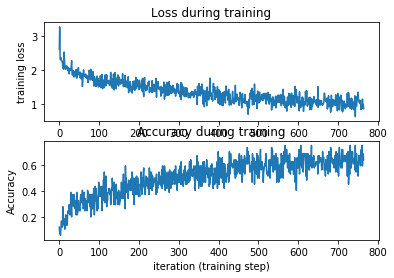

train for epoch 1
iteration (800): loss = 0.790, accuracy = 0.688
iteration (850): loss = 0.944, accuracy = 0.656
iteration (900): loss = 0.729, accuracy = 0.734
iteration (950): loss = 0.857, accuracy = 0.672
iteration (1000): loss = 0.938, accuracy = 0.578
iteration (1050): loss = 1.129, accuracy = 0.672
iteration (1100): loss = 1.032, accuracy = 0.641
iteration (1150): loss = 0.619, accuracy = 0.797
iteration (1200): loss = 0.944, accuracy = 0.609
iteration (1250): loss = 0.829, accuracy = 0.703
iteration (1300): loss = 0.712, accuracy = 0.734
iteration (1350): loss = 0.838, accuracy = 0.703
iteration (1400): loss = 0.610, accuracy = 0.750
iteration (1450): loss = 1.011, accuracy = 0.688
iteration (1500): loss = 0.940, accuracy = 0.641
validation for epoch 1
-  epoch 1: validation accuracy = 0.729


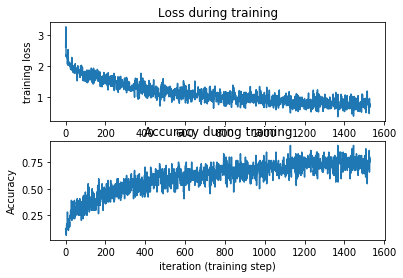

train for epoch 2
iteration (1550): loss = 0.847, accuracy = 0.688
iteration (1600): loss = 0.796, accuracy = 0.719
iteration (1650): loss = 0.921, accuracy = 0.688
iteration (1700): loss = 0.943, accuracy = 0.703
iteration (1750): loss = 0.574, accuracy = 0.797
iteration (1800): loss = 0.740, accuracy = 0.766
iteration (1850): loss = 0.910, accuracy = 0.672
iteration (1900): loss = 0.478, accuracy = 0.828
iteration (1950): loss = 0.829, accuracy = 0.719
iteration (2000): loss = 0.694, accuracy = 0.734
iteration (2050): loss = 0.746, accuracy = 0.750
iteration (2100): loss = 0.608, accuracy = 0.781
iteration (2150): loss = 0.709, accuracy = 0.703
iteration (2200): loss = 0.826, accuracy = 0.750
iteration (2250): loss = 0.499, accuracy = 0.828
validation for epoch 2
-  epoch 2: validation accuracy = 0.748


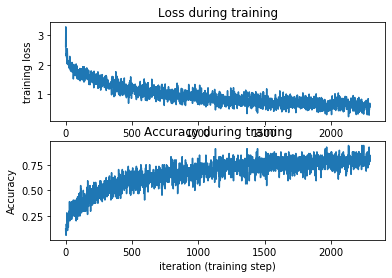

train for epoch 3
iteration (2300): loss = 0.601, accuracy = 0.812
iteration (2350): loss = 0.680, accuracy = 0.766
iteration (2400): loss = 0.647, accuracy = 0.750
iteration (2450): loss = 0.961, accuracy = 0.734
iteration (2500): loss = 0.357, accuracy = 0.906
iteration (2550): loss = 0.689, accuracy = 0.766
iteration (2600): loss = 0.720, accuracy = 0.766
iteration (2650): loss = 0.547, accuracy = 0.828
iteration (2700): loss = 0.611, accuracy = 0.859
iteration (2750): loss = 0.569, accuracy = 0.781
iteration (2800): loss = 0.517, accuracy = 0.828
iteration (2850): loss = 0.472, accuracy = 0.844
iteration (2900): loss = 0.376, accuracy = 0.859
iteration (2950): loss = 0.498, accuracy = 0.844
iteration (3000): loss = 0.299, accuracy = 0.891
iteration (3050): loss = 0.490, accuracy = 0.844
validation for epoch 3
-  epoch 3: validation accuracy = 0.783


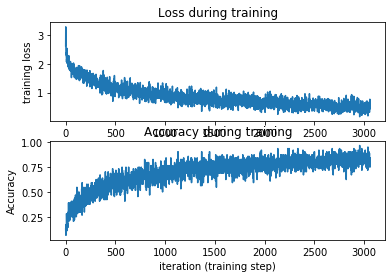

train for epoch 4
iteration (3100): loss = 0.253, accuracy = 0.906
iteration (3150): loss = 0.318, accuracy = 0.859
iteration (3200): loss = 0.469, accuracy = 0.812
iteration (3250): loss = 0.548, accuracy = 0.797
iteration (3300): loss = 0.213, accuracy = 0.922
iteration (3350): loss = 0.600, accuracy = 0.828
iteration (3400): loss = 0.456, accuracy = 0.859
iteration (3450): loss = 0.377, accuracy = 0.875
iteration (3500): loss = 0.325, accuracy = 0.891
iteration (3550): loss = 0.595, accuracy = 0.797
iteration (3600): loss = 0.482, accuracy = 0.875
iteration (3650): loss = 0.526, accuracy = 0.875
iteration (3700): loss = 0.297, accuracy = 0.875
iteration (3750): loss = 0.336, accuracy = 0.922
iteration (3800): loss = 0.282, accuracy = 0.891
validation for epoch 4
-  epoch 4: validation accuracy = 0.779


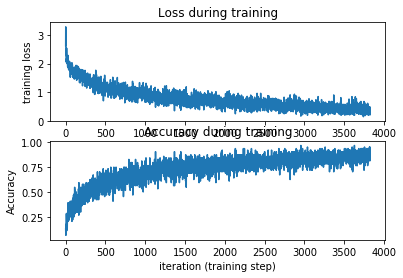

train for epoch 5
iteration (3850): loss = 0.406, accuracy = 0.875
iteration (3900): loss = 0.500, accuracy = 0.875
iteration (3950): loss = 0.379, accuracy = 0.891
iteration (4000): loss = 0.293, accuracy = 0.875
iteration (4050): loss = 0.344, accuracy = 0.875
iteration (4100): loss = 0.227, accuracy = 0.891
iteration (4150): loss = 0.306, accuracy = 0.875
iteration (4200): loss = 0.204, accuracy = 0.922
iteration (4250): loss = 0.469, accuracy = 0.875
iteration (4300): loss = 0.319, accuracy = 0.906
iteration (4350): loss = 0.524, accuracy = 0.844
iteration (4400): loss = 0.351, accuracy = 0.828
iteration (4450): loss = 0.293, accuracy = 0.906
iteration (4500): loss = 0.321, accuracy = 0.906
iteration (4550): loss = 0.288, accuracy = 0.938
validation for epoch 5
-  epoch 5: validation accuracy = 0.781


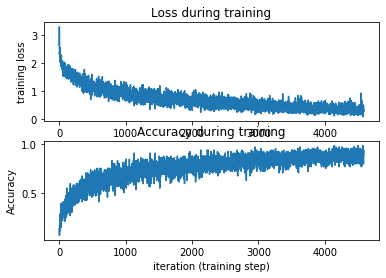

train for epoch 6
iteration (4600): loss = 0.318, accuracy = 0.891
iteration (4650): loss = 0.418, accuracy = 0.859
iteration (4700): loss = 0.388, accuracy = 0.875
iteration (4750): loss = 0.409, accuracy = 0.875
iteration (4800): loss = 0.204, accuracy = 0.953
iteration (4850): loss = 0.310, accuracy = 0.891
iteration (4900): loss = 0.292, accuracy = 0.906
iteration (4950): loss = 0.394, accuracy = 0.906
iteration (5000): loss = 0.251, accuracy = 0.891
iteration (5050): loss = 0.291, accuracy = 0.891
iteration (5100): loss = 0.409, accuracy = 0.797
iteration (5150): loss = 0.103, accuracy = 0.969
iteration (5200): loss = 0.211, accuracy = 0.906
iteration (5250): loss = 0.103, accuracy = 0.969
iteration (5300): loss = 0.184, accuracy = 0.906
iteration (5350): loss = 0.201, accuracy = 0.891
validation for epoch 6
-  epoch 6: validation accuracy = 0.781


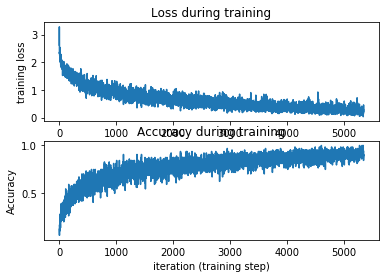

train for epoch 7
iteration (5400): loss = 0.179, accuracy = 0.922
iteration (5450): loss = 0.364, accuracy = 0.891
iteration (5500): loss = 0.129, accuracy = 0.938
iteration (5550): loss = 0.273, accuracy = 0.906
iteration (5600): loss = 0.349, accuracy = 0.875
iteration (5650): loss = 0.186, accuracy = 0.953
iteration (5700): loss = 0.226, accuracy = 0.906
iteration (5750): loss = 0.147, accuracy = 0.938
iteration (5800): loss = 0.266, accuracy = 0.938
iteration (5850): loss = 0.348, accuracy = 0.891
iteration (5900): loss = 0.111, accuracy = 0.969
iteration (5950): loss = 0.236, accuracy = 0.906
iteration (6000): loss = 0.210, accuracy = 0.938
iteration (6050): loss = 0.131, accuracy = 0.969
iteration (6100): loss = 0.111, accuracy = 0.969
validation for epoch 7
-  epoch 7: validation accuracy = 0.811


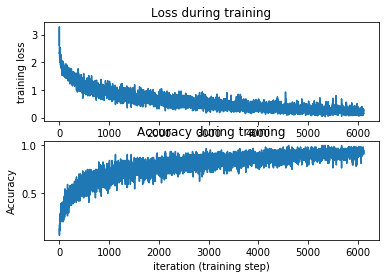

train for epoch 8
iteration (6150): loss = 0.178, accuracy = 0.969
iteration (6200): loss = 0.195, accuracy = 0.938
iteration (6250): loss = 0.107, accuracy = 0.953
iteration (6300): loss = 0.149, accuracy = 0.938
iteration (6350): loss = 0.090, accuracy = 0.953
iteration (6400): loss = 0.179, accuracy = 0.953
iteration (6450): loss = 0.234, accuracy = 0.938
iteration (6500): loss = 0.256, accuracy = 0.891
iteration (6550): loss = 0.229, accuracy = 0.953
iteration (6600): loss = 0.307, accuracy = 0.938
iteration (6650): loss = 0.329, accuracy = 0.844
iteration (6700): loss = 0.367, accuracy = 0.875
iteration (6750): loss = 0.280, accuracy = 0.906
iteration (6800): loss = 0.153, accuracy = 0.922
iteration (6850): loss = 0.087, accuracy = 0.953
validation for epoch 8
-  epoch 8: validation accuracy = 0.778


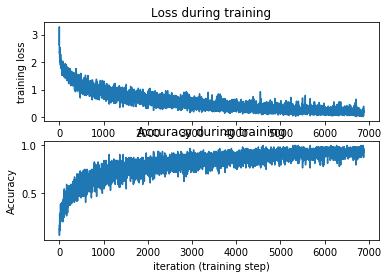

train for epoch 9
iteration (6900): loss = 0.097, accuracy = 0.953
iteration (6950): loss = 0.369, accuracy = 0.859
iteration (7000): loss = 0.195, accuracy = 0.938
iteration (7050): loss = 0.154, accuracy = 0.938
iteration (7100): loss = 0.312, accuracy = 0.891
iteration (7150): loss = 0.189, accuracy = 0.969
iteration (7200): loss = 0.230, accuracy = 0.953
iteration (7250): loss = 0.256, accuracy = 0.891
iteration (7300): loss = 0.044, accuracy = 1.000
iteration (7350): loss = 0.038, accuracy = 0.984
iteration (7400): loss = 0.431, accuracy = 0.891
iteration (7450): loss = 0.212, accuracy = 0.938
iteration (7500): loss = 0.155, accuracy = 0.953
iteration (7550): loss = 0.188, accuracy = 0.922
iteration (7600): loss = 0.043, accuracy = 0.969
validation for epoch 9
-  epoch 9: validation accuracy = 0.762


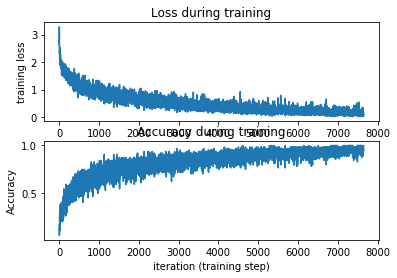

train for epoch 10
iteration (7650): loss = 0.224, accuracy = 0.938
iteration (7700): loss = 0.080, accuracy = 0.969
iteration (7750): loss = 0.139, accuracy = 0.953
iteration (7800): loss = 0.211, accuracy = 0.953
iteration (7850): loss = 0.252, accuracy = 0.938
iteration (7900): loss = 0.149, accuracy = 0.938
iteration (7950): loss = 0.054, accuracy = 1.000
iteration (8000): loss = 0.204, accuracy = 0.922
iteration (8050): loss = 0.211, accuracy = 0.953
iteration (8100): loss = 0.310, accuracy = 0.953
iteration (8150): loss = 0.199, accuracy = 0.953
iteration (8200): loss = 0.122, accuracy = 0.953
iteration (8250): loss = 0.148, accuracy = 0.969
iteration (8300): loss = 0.080, accuracy = 0.953
iteration (8350): loss = 0.139, accuracy = 0.953
iteration (8400): loss = 0.232, accuracy = 0.938
validation for epoch 10
-  epoch 10: validation accuracy = 0.783


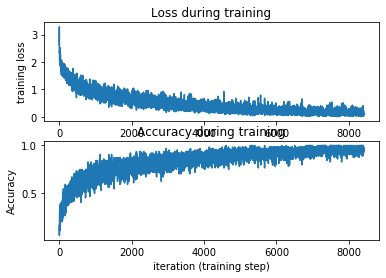

train for epoch 11
iteration (8450): loss = 0.083, accuracy = 0.969
iteration (8500): loss = 0.054, accuracy = 0.984
iteration (8550): loss = 0.079, accuracy = 0.969
iteration (8600): loss = 0.073, accuracy = 0.969
iteration (8650): loss = 0.030, accuracy = 1.000
iteration (8700): loss = 0.105, accuracy = 0.969
iteration (8750): loss = 0.175, accuracy = 0.969
iteration (8800): loss = 0.122, accuracy = 0.953
iteration (8850): loss = 0.054, accuracy = 0.984
iteration (8900): loss = 0.040, accuracy = 1.000
iteration (8950): loss = 0.206, accuracy = 0.953
iteration (9000): loss = 0.151, accuracy = 0.922
iteration (9050): loss = 0.110, accuracy = 0.969
iteration (9100): loss = 0.090, accuracy = 0.969
iteration (9150): loss = 0.129, accuracy = 0.969
validation for epoch 11
-  epoch 11: validation accuracy = 0.786


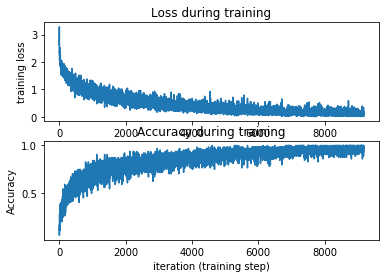

train for epoch 12
iteration (9200): loss = 0.074, accuracy = 0.969
iteration (9250): loss = 0.181, accuracy = 0.953
iteration (9300): loss = 0.088, accuracy = 0.969
iteration (9350): loss = 0.131, accuracy = 0.938
iteration (9400): loss = 0.078, accuracy = 0.953
iteration (9450): loss = 0.047, accuracy = 0.953
iteration (9500): loss = 0.056, accuracy = 0.984
iteration (9550): loss = 0.285, accuracy = 0.922
iteration (9600): loss = 0.031, accuracy = 0.984
iteration (9650): loss = 0.066, accuracy = 0.969
iteration (9700): loss = 0.198, accuracy = 0.922
iteration (9750): loss = 0.016, accuracy = 1.000
iteration (9800): loss = 0.015, accuracy = 1.000
iteration (9850): loss = 0.075, accuracy = 0.969
iteration (9900): loss = 0.128, accuracy = 0.953
validation for epoch 12
-  epoch 12: validation accuracy = 0.794


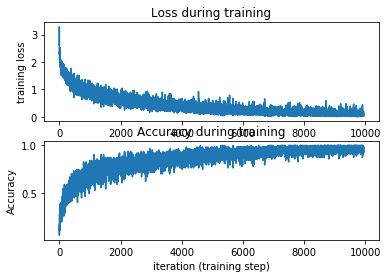

train for epoch 13
iteration (9950): loss = 0.138, accuracy = 0.969
iteration (10000): loss = 0.137, accuracy = 0.953
iteration (10050): loss = 0.196, accuracy = 0.922
iteration (10100): loss = 0.337, accuracy = 0.906
iteration (10150): loss = 0.106, accuracy = 0.953
iteration (10200): loss = 0.042, accuracy = 0.984
iteration (10250): loss = 0.062, accuracy = 0.953
iteration (10300): loss = 0.127, accuracy = 0.938
iteration (10350): loss = 0.193, accuracy = 0.969
iteration (10400): loss = 0.078, accuracy = 0.969
iteration (10450): loss = 0.018, accuracy = 1.000
iteration (10500): loss = 0.181, accuracy = 0.969
iteration (10550): loss = 0.040, accuracy = 1.000
iteration (10600): loss = 0.089, accuracy = 0.969
iteration (10650): loss = 0.022, accuracy = 0.984
iteration (10700): loss = 0.184, accuracy = 0.953
validation for epoch 13
-  epoch 13: validation accuracy = 0.786


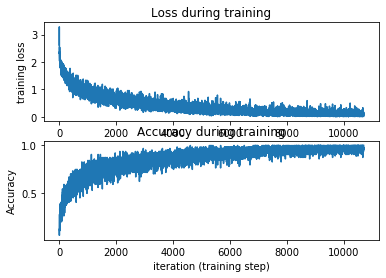

train for epoch 14
iteration (10750): loss = 0.054, accuracy = 0.969
iteration (10800): loss = 0.020, accuracy = 0.984
iteration (10850): loss = 0.060, accuracy = 0.969
iteration (10900): loss = 0.104, accuracy = 0.969
iteration (10950): loss = 0.183, accuracy = 0.953
iteration (11000): loss = 0.106, accuracy = 0.969
iteration (11050): loss = 0.100, accuracy = 0.969
iteration (11100): loss = 0.071, accuracy = 0.953
iteration (11150): loss = 0.020, accuracy = 0.984
iteration (11200): loss = 0.183, accuracy = 0.953
iteration (11250): loss = 0.053, accuracy = 0.984
iteration (11300): loss = 0.205, accuracy = 0.922
iteration (11350): loss = 0.254, accuracy = 0.938
iteration (11400): loss = 0.140, accuracy = 0.984
iteration (11450): loss = 0.107, accuracy = 0.984
validation for epoch 14
-  epoch 14: validation accuracy = 0.793


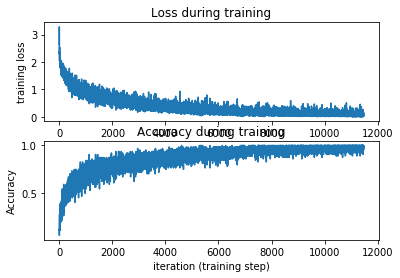

***** test accuracy: 0.787
Model saved in lib/tf_models/problem2/csci-599_mine.ckpt


In [68]:
tf.reset_default_graph()

with tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)) as sess:
    with tf.device('/cpu:0'):
        model = YourModel()
        model.train(sess, X_train, Y_train, X_val, Y_val)
        accuracy = model.evaluate(sess, X_test, Y_test)
        print('***** test accuracy: %.3f' % accuracy)
        # Save your model
        saver = tf.train.Saver()
        model_path = saver.save(sess, "lib/tf_models/problem2/csci-599_mine.ckpt")
        print("Model saved in %s" % model_path)

In [69]:
tf.reset_default_graph()

# Load your model
model = YourModel()
sess = tf.Session() 
saver = tf.train.Saver()
saver.restore(sess, "lib/tf_models/problem2/csci-599_mine.ckpt")

-----  Your model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 32, 32, 32)
conv2 layer: (?, 16, 16, 64)
conv3 layer: (?, 16, 16, 64)
conv4 layer: (?, 8, 8, 128)
conv5 layer: (?, 8, 8, 128)
conv6 layer: (?, 4, 4, 128)
flat layer: (?, 2048)
fc4 layer: (?, 512)
fc6 layer: (?, 10)


W1002 23:09:22.483864  3884 deprecation.py:323] From C:\Users\mohan\Anaconda3\envs\tensorflow_cpu_env\lib\site-packages\tensorflow\python\training\saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
